##### Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.data import Dataset, AUTOTUNE

from tqdm import tqdm

In [5]:
# from huggingface_hub import notebook_login

# notebook_login()

In [6]:
data = pd.read_csv('data/email_spam.csv')

In [7]:
data.head()

,Unnamed: 0,text,spam
0,0,naturally irresistible corporate identity lt r...,1
1,1,stock trading gunslinger fanny merrill muzo co...,1
2,2,unbelievable neurladds made easy im urladdg sh...,1
3,3,color printing special request additional info...,1
4,4,money get softurladd cds softurladd compatibil...,1


<AxesSubplot:>

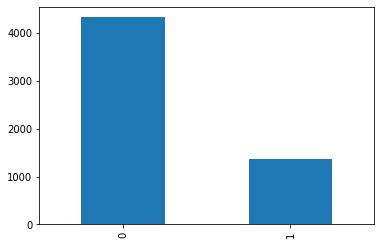

In [4]:
data["spam"].value_counts().plot(kind='bar')

##### train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['spam'], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [6]:
# del data

##### Bert

In [7]:
from transformers import BertTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [24]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in tqdm(sentences):
        inputs = tokenizer.encode_plus(
            sentence, add_special_tokens=True, max_length=128, padding='max_length',
            return_attention_mask=True, return_token_type_ids=True, truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


In [25]:
train_input_ids, train_input_masks, train_input_segments = tokenize(X_train, tokenizer)
test_input_ids, test_input_masks, test_input_segments = tokenize(X_test, tokenizer)
val_input_ids, val_input_masks, val_input_segments = tokenize(X_val, tokenizer)

100%|██████████| 513/513 [00:03<00:00, 165.04it/s]


In [ ]:
# del X_train
# del X_test
# del X_val

In [26]:
train_encodings = dict({
    "input_ids": train_input_ids,
    "attention_mask": train_input_masks,
#     "token_type_ids": train_input_segments
})

val_encodings = dict({
    "input_ids": val_input_ids,
    "attention_mask": val_input_masks,
#     "token_type_ids": val_input_segments
})

test_encodings = dict({
    "input_ids": test_input_ids,
    "attention_mask": test_input_masks,
#     "token_type_ids": test_input_segments
})

In [ ]:
# del train_input_ids
# del train_input_masks
# del train_input_segments
# del test_input_ids
# del test_input_masks
# del test_input_segments
# del val_input_ids
# del val_input_masks
# del val_input_segments

In [27]:
train_dataset = Dataset.from_tensor_slices((
    train_encodings,
    y_train
))

val_dataset = Dataset.from_tensor_slices((
    val_encodings,
    y_val
))

test_dataset = Dataset.from_tensor_slices((
    test_encodings,
    y_test
))

In [28]:
# del train_encodings
# del val_encodings
# del test_encodings
# del y_train
# del y_test
# del y_val

In [29]:
train_ds = train_dataset.shuffle(1000).batch(64)
val_ds = val_dataset.batch(64)

In [45]:
test_ds = test_dataset.batch(64)

In [30]:
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow import device

In [38]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use i

In [39]:
def custom_model():
    x = Input(shape=(128,), dtype='int32', name='input_ids')
    y = Input(shape=(128,), dtype='int32', name='attention_mask')
    z = Input(shape=(512,))
    out = model.layers[0]([x,y]).last_hidden_state
    out = model.layers[1](out)
    out = model.layers[2](out)
    out = model.layers[3](out)
    out = Flatten()(out)
    out = Dense(128, activation='relu')(out)
    out = Dense(1,activation='sigmoid')(out)
    mod = Model([x,y],out)
    return mod

tf_model = custom_model()
tf_model

In [40]:
tf_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
pre_classifier (Dense)          (None, 128, 768)     590592      distilbert[0][0]           

In [41]:
tf_model.layers[2].trainable=False
# tf_model.layers[3].trainable=False
# tf_model.layers[4].trainable=False

In [42]:
tf_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
pre_classifier (Dense)          (None, 128, 768)     590592      distilbert[0][0]           

In [43]:
optimizer = Adam(learning_rate=5e-5)
tf_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
history = tf_model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
73/73 [==============================] - 20s 199ms/step - loss: 0.5478 - accuracy: 0.7480 - val_loss: 0.4286 - val_accuracy: 0.7856
Epoch 2/20
73/73 [==============================] - 13s 179ms/step - loss: 0.3566 - accuracy: 0.8274 - val_loss: 0.2437 - val_accuracy: 0.9357
Epoch 3/20
73/73 [==============================] - 13s 178ms/step - loss: 0.1791 - accuracy: 0.9419 - val_loss: 0.1489 - val_accuracy: 0.9474
Epoch 4/20
73/73 [==============================] - 13s 179ms/step - loss: 0.1263 - accuracy: 0.9538 - val_loss: 0.1540 - val_accuracy: 0.9435
Epoch 5/20
73/73 [==============================] - 13s 178ms/step - loss: 0.1045 - accuracy: 0.9592 - val_loss: 0.1140 - val_accuracy: 0.9571
Epoch 6/20
73/73 [==============================] - 13s 180ms/step - loss: 0.0982 - accuracy: 0.9627 - val_loss: 0.1161 - val_accuracy: 0.9630
Epoch 7/20
73/73 [==============================] - 13s 178ms/step - loss: 0.0898 - accuracy: 0.9655 - val_loss: 0.1063 - val_accuracy: 0.9669

In [46]:
tf_model.evaluate(test_ds)

9/9 [==============================] - 1s 151ms/step - loss: 0.0558 - accuracy: 0.9789


[0.055765893310308456, 0.9789473414421082]

In [48]:
import matplotlib.pyplot as plt

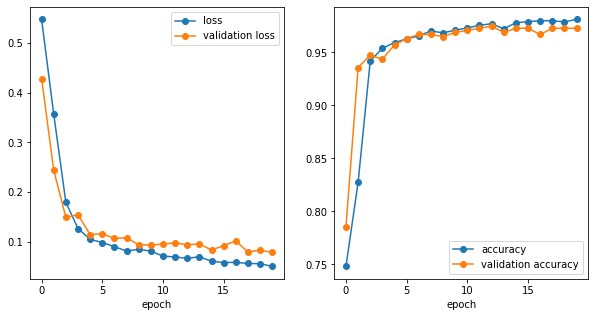

In [49]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'o-', label='loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'o-', 
         label='accuracy')
plt.plot(history.history['val_accuracy'], 'o-', 
         label='validation accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [50]:
tf_model.save_weights("weights.h5")